## Data Description and Analysis

In [1]:
## !pip install sqlalchemy
## !pip install pyhive
## !pip install thrift
## !pip install sasl
## !pip install thrift-sasl 
## !pip install psycopg2-binary
!pip install presto-python-client
!pip install pandas plotnine

import prestodb
import sqlalchemy
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 500)

import gc
import os

# matplotlib and seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 #resolution
matplotlib.rcParams['figure.figsize'] = (8,6) #figure size

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()


The dataset contains relational set of files describing customers' orders over time. For each user, 4 to 100 orders are provided with the sequence of products purchased in each order. The data of the order's week and hour of the day as well as a relative measure of time between orders is provided.

**Files in the Dataset:** 

In [2]:
conn=prestodb.dbapi.connect(
    host='presto-service',
    port=8282,
    user='presto',
    catalog='hive',
    schema='source',
)

fetchlimit = 100000

cur = conn.cursor()
cur.execute('show tables')
pd.DataFrame.from_records(cur.fetchall(), columns = [i[0] for i in cur.description])

,Table
0,aisles
1,departments
2,order_products
3,order_products_new
4,orders
5,products


In [3]:
cur.execute('select * from source.aisles limit ' + str(fetchlimit))
aisles = pd.DataFrame.from_records(cur.fetchall(), columns = [i[0] for i in cur.description])

In [4]:
cur.execute('select * from source.aisles limit '  + str(fetchlimit))
aisles = pd.DataFrame.from_records(cur.fetchall(), columns = [i[0] for i in cur.description])

cur.execute('select * from source.departments limit '  + str(fetchlimit))
departments = pd.DataFrame.from_records(cur.fetchall(), columns = [i[0] for i in cur.description])

cur.execute('select * from source.orders limit '  + str(fetchlimit))
orders = pd.DataFrame.from_records(cur.fetchall(), columns = [i[0] for i in cur.description])

cur.execute('select * from source.products limit '  + str(fetchlimit))
products = pd.DataFrame.from_records(cur.fetchall(), columns = [i[0] for i in cur.description])

In [5]:

cur.execute('select * from source.order_products limit '  + str(fetchlimit))
order_products_prior = pd.DataFrame.from_records(cur.fetchall(), columns = [i[0] for i in cur.description])

cur.execute('select * from source.order_products_new limit '  + str(fetchlimit))
order_products_train = pd.DataFrame.from_records(cur.fetchall(), columns = [i[0] for i in cur.description])


### aisles: 
This file contains different aisles and there are total 134 unique aisles.

In [6]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [7]:
aisles.tail()

,aisle_id,aisle
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief
133,134,specialty wines champagnes


In [8]:
len(aisles.aisle.unique())

134

In [9]:
aisles.aisle.unique()

array(['prepared soups salads', 'specialty cheeses',
       'energy granola bars', 'instant foods',
       'marinades meat preparation', 'other', 'packaged meat',
       'bakery desserts', 'pasta sauce', 'kitchen supplies',
       'cold flu allergy', 'fresh pasta', 'prepared meals',
       'tofu meat alternatives', 'packaged seafood', 'fresh herbs',
       'baking ingredients', 'bulk dried fruits vegetables',
       'oils vinegars', 'oral hygiene', 'packaged cheese', 'hair care',
       'popcorn jerky', 'fresh fruits', 'soap', 'coffee', 'beers coolers',
       'red wines', 'honeys syrups nectars', 'latino foods',
       'refrigerated', 'packaged produce', 'kosher foods',
       'frozen meat seafood', 'poultry counter', 'butter',
       'ice cream ice', 'frozen meals', 'seafood counter',
       'dog food care', 'cat food care', 'frozen vegan vegetarian',
       'buns rolls', 'eye ear care', 'candy chocolate', 'mint gum',
       'vitamins supplements', 'breakfast bars pastries',
       '

### departments: 
This file contains different departments and there are total 21 unique departments.

In [10]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [11]:
departments.tail()

,department_id,department
16,17,household
17,18,babies
18,19,snacks
19,20,deli
20,21,missing


In [12]:
len(departments.department.unique())

21

In [13]:
departments.department.unique()

array(['frozen', 'other', 'bakery', 'produce', 'alcohol', 'international',
       'beverages', 'pets', 'dry goods pasta', 'bulk', 'personal care',
       'meat seafood', 'pantry', 'breakfast', 'canned goods',
       'dairy eggs', 'household', 'babies', 'snacks', 'deli', 'missing'],
      dtype=object)

### orders: 
This file contains all the orders made by different users. From below analysis, we can conclude following:

- There are total 3421083 orders made by total 206209 users.
- There are three sets of orders: Prior, Train and Test. The distributions of orders in Train and Test sets are similar whereas the distribution of orders in Prior set is different.
- The total orders per customer ranges from 0 to 100. 
- Based on the plot of 'Orders VS Day of Week' we can map 0 and 1 as Saturday and Sunday respectively based on the assumption that most of the people buy groceries on weekends.
- Majority of the orders are made during the day time.
- Customers order once in a week which is supported by peaks at 7, 14, 21 and 30 in 'Orders VS Days since prior order' graph.
- Based on the heatmap between 'Day of Week' and 'Hour of Day,' we can say that Saturday afternoons and Sunday mornings are prime time for orders.

In [14]:
orders.head(12)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [15]:
orders.tail()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
9995,2650063,633,prior,1,3,12,NaN
9996,3051335,633,prior,2,6,19,17.0
9997,1901440,633,prior,3,1,9,30.0
9998,1624343,633,prior,4,1,13,30.0
9999,3128663,633,test,5,3,19,16.0


In [16]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                10000 non-null  int64  
 1   user_id                 10000 non-null  int64  
 2   eval_set                10000 non-null  object 
 3   order_number            10000 non-null  int64  
 4   order_dow               10000 non-null  int64  
 5   order_hour_of_day       10000 non-null  int64  
 6   days_since_prior_order  9367 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 547.0+ KB


In [17]:
len(orders.order_id.unique())

10000

In [18]:
len(orders.user_id.unique())

633

In [19]:
orders.eval_set.value_counts()

prior    9367
train     407
test      226
Name: eval_set, dtype: int64

In [20]:
orders.order_number.describe().apply(lambda x: format(x, '.2f'))

count    10000.00
mean        16.38
std         17.36
min          1.00
25%          4.00
50%         10.00
75%         22.00
max        100.00
Name: order_number, dtype: object

In [21]:
order_number = orders.groupby('user_id')['order_number'].max()
order_number = order_number.value_counts()

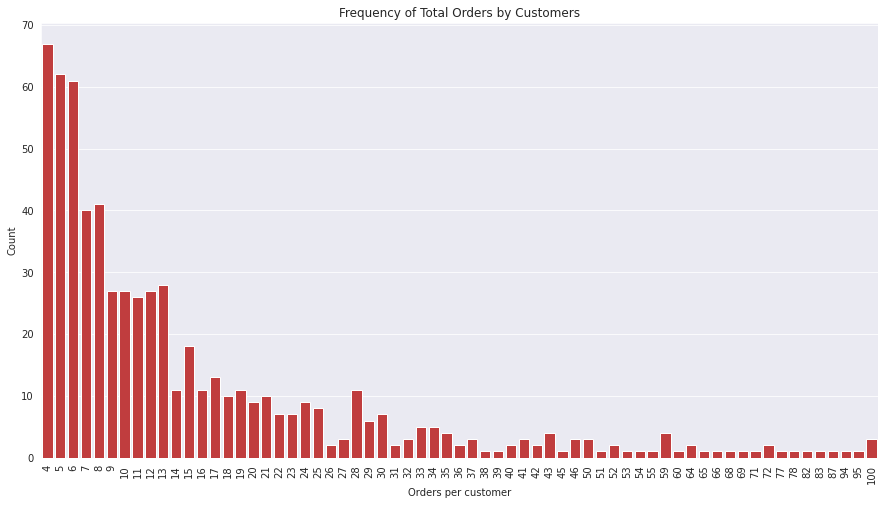

In [22]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(x = order_number.index, y = order_number.values, color = color[3])
ax.set_xlabel('Orders per customer')
ax.set_ylabel('Count')
ax.xaxis.set_tick_params(rotation=90, labelsize=10)
ax.set_title('Frequency of Total Orders by Customers')
fig.savefig('./plot/Frequency of Total Orders by Customers.png')

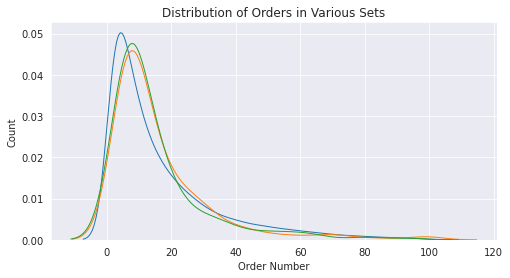

In [23]:
fig, ax = plt.subplots(figsize = (8,4))
ax = sns.kdeplot(orders.order_number[orders.eval_set == 'prior'], label = "Prior set", lw = 1)
ax = sns.kdeplot(orders.order_number[orders.eval_set == 'train'], label = "Train set", lw = 1)
ax = sns.kdeplot(orders.order_number[orders.eval_set == 'test'], label = "Test set", lw = 1)
ax.set_xlabel('Order Number')
ax.set_ylabel('Count')
ax.tick_params(axis = 'both', labelsize = 10)
ax.set_title('Distribution of Orders in Various Sets')
fig.savefig('./plot/Distribution of Orders in Various Sets.png')
plt.show()

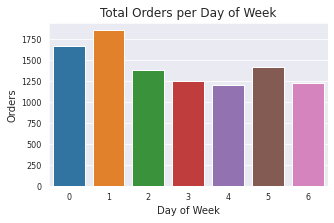

In [24]:
fig, ax = plt.subplots(figsize = (5,3))
ax = sns.countplot(x=orders.order_dow)
ax.set_xlabel('Day of Week', size = 10)
ax.set_ylabel('Orders', size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
ax.set_title('Total Orders per Day of Week')
fig.savefig('./plot/Total Orders per Day of Week.png')
plt.show()

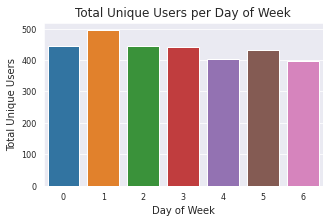

In [25]:
temp_df = orders.groupby('order_dow')['user_id'].nunique()

fig, ax = plt.subplots(figsize = (5,3))
ax = sns.barplot(x = temp_df.index, y = temp_df.values)
ax.set_xlabel('Day of Week', size = 10)
ax.set_ylabel('Total Unique Users', size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
ax.set_title('Total Unique Users per Day of Week')
fig.savefig('./plot/Total Unique Users per Day of Week.png')
plt.show()

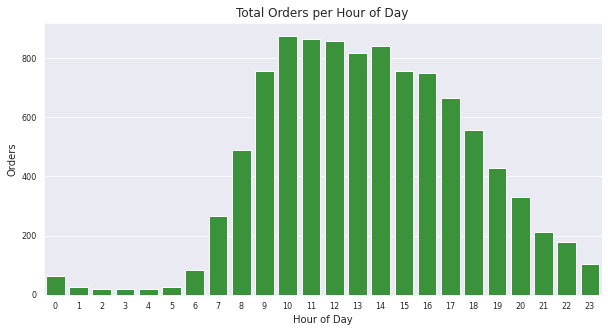

In [26]:
fig, ax = plt.subplots(figsize = (10,5))
ax = sns.countplot(x=orders.order_hour_of_day, color = color[2])
ax.set_xlabel('Hour of Day', size = 10 )
ax.set_ylabel('Orders', size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
ax.set_title('Total Orders per Hour of Day')
fig.savefig('./plot/Total Orders per Hour of Day.png')
plt.show()

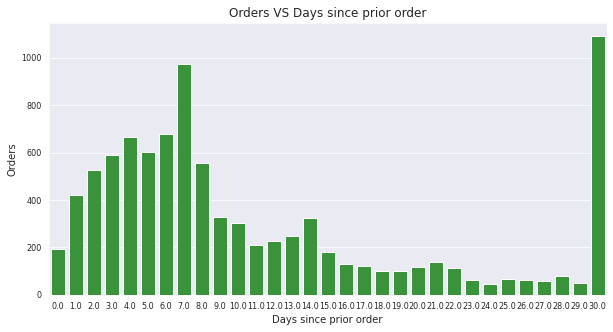

In [27]:
fig, ax = plt.subplots(figsize = (10,5))
ax = sns.countplot(x=orders.days_since_prior_order, color = color[2])
ax.set_xlabel('Days since prior order', size = 10)
ax.set_ylabel('Orders', size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
ax.set_title('Orders VS Days since prior order')
fig.savefig('./plot/Orders VS Days since prior order.png')
plt.show()

In [28]:
temp_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
temp_df = temp_df.pivot('order_dow', 'order_hour_of_day', 'order_number')
temp_df.head()

order_hour_of_day,0,1,2,3,4,...,19,20,21,22,23
order_dow,,,,,,,,,,,
0,14.0,6.0,6.0,3.0,1.0,...,68.0,71.0,45.0,35.0,15.0
1,9.0,6.0,NaN,3.0,3.0,...,78.0,57.0,34.0,37.0,16.0
2,9.0,3.0,1.0,4.0,1.0,...,57.0,35.0,25.0,18.0,17.0
3,4.0,4.0,4.0,2.0,2.0,...,61.0,49.0,30.0,15.0,14.0
4,7.0,4.0,NaN,2.0,7.0,...,50.0,45.0,30.0,24.0,9.0


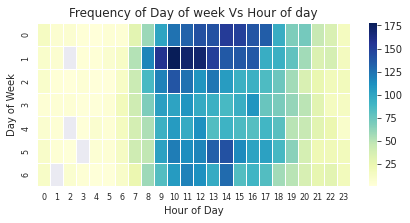

In [29]:
ax = plt.subplots(figsize=(7,3))
ax = sns.heatmap(temp_df, cmap="YlGnBu", linewidths=.5)
ax.set_title("Frequency of Day of week Vs Hour of day", size = 12)
ax.set_xlabel("Hour of Day", size = 10)
ax.set_ylabel("Day of Week", size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
fig = ax.get_figure()
fig.savefig("./plot/Frequency of Day of week Vs Hour of day.png")
plt.show()

### order_products_prior:

This file gives information about which products were ordered and in which order they were added in the cart. It also tells us that if the product was reordered or not. 

- In this file there is an information of total 3214874 orders through which total 49677 products were ordered. 
- From the 'Count VS Items in cart' plot, we can say that most of the people buy 1-15 items in an order and there were a maximum of 145 items in an order.
- The percentage of reorder items in this set is 58.97%.

In [30]:
order_products_prior.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,2988749,15485,10,1
1,2988750,4595,1,1
2,2988750,37417,2,0
3,2988750,49605,3,0
4,2988750,8214,4,0
5,2988750,23313,5,0
6,2988750,38730,6,1
7,2988750,8367,7,1
8,2988750,40214,8,1
9,2988750,29503,9,1


In [31]:
order_products_prior.tail()

,order_id,product_id,add_to_cart_order,reordered
9995,2989795,48626,13,0
9996,2989795,9864,14,0
9997,2989795,21573,15,0
9998,2989795,43961,16,1
9999,2989795,34969,17,0


In [32]:
len(order_products_prior.order_id.unique())

994

In [33]:
len(order_products_prior.product_id.unique())

4545

In [34]:
add_to_cart_order_prior = order_products_prior.groupby('order_id')['add_to_cart_order'].count()
add_to_cart_order_prior = add_to_cart_order_prior.value_counts()

In [35]:
add_to_cart_order_prior.head()

4    86
7    68
6    66
1    66
5    65
Name: add_to_cart_order, dtype: int64

In [36]:
add_to_cart_order_prior.tail()

38    1
37    1
36    1
44    1
39    1
Name: add_to_cart_order, dtype: int64

In [37]:
add_to_cart_order_prior.index.max()

52

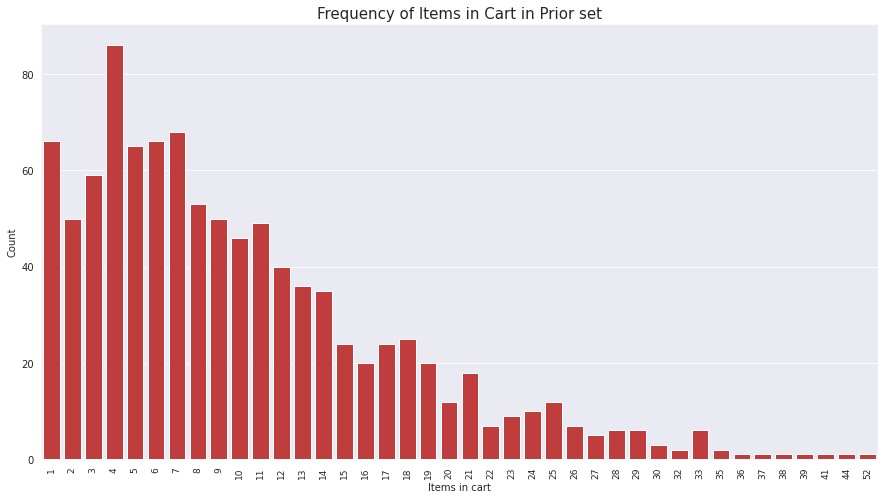

In [38]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(x = add_to_cart_order_prior.index, y = add_to_cart_order_prior.values, color = color[3])
ax.set_xlabel('Items in cart')
ax.set_ylabel('Count')
ax.xaxis.set_tick_params(rotation=90, labelsize = 9)
ax.set_title('Frequency of Items in Cart in Prior set', size = 15)
fig.savefig('./plot/Frequency of Items in Cart in Prior set.png')

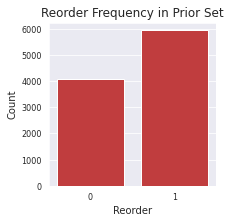

In [39]:
fig, ax = plt.subplots(figsize=(3,3))
ax = sns.barplot(x = order_products_prior.reordered.value_counts().index, 
                y = order_products_prior.reordered.value_counts().values, color = color[3])
ax.set_xlabel('Reorder', size = 10)
ax.set_ylabel('Count', size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
ax.ticklabel_format(style='plain', axis='y')
ax.set_title('Reorder Frequency in Prior Set')
fig.savefig('./plot/Reorder Frequency in Prior Set')
plt.show()

In [40]:
print('Percentage of reorder in prior set:',
      format(order_products_prior[order_products_prior.reordered == 1].shape[0]*100/order_products_prior.shape[0], '.2f'))

Percentage of reorder in prior set: 59.35


### order_products_train:

This file gives information about which products were ordered and in which order they were added in the cart. It also tells us that if the product was reordered or not. 

- In this file there is an information of total 131209 orders through which total 39123 products were ordered. 
- From the 'Count VS Items in cart' plot, we can say that most of the people buy 1-15 items in an order and there were a maximum of 145 items in an order.
- The percentage of reorder items in this set is 59.86%.

In [41]:
order_products_train.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


In [42]:
order_products_train.tail()

,order_id,product_id,add_to_cart_order,reordered
9995,23978,4565,16,1
9996,23978,40287,17,0
9997,23978,1890,18,1
9998,23993,5450,1,1
9999,23993,24852,2,1


In [43]:
len(order_products_train.order_id.unique())

939

In [44]:
len(order_products_train.product_id.unique())

4660

In [45]:
add_to_cart_order_train = order_products_prior.groupby('order_id')['add_to_cart_order'].count()
add_to_cart_order_train = add_to_cart_order_train.value_counts()

In [46]:
add_to_cart_order_train.head()

4    86
7    68
6    66
1    66
5    65
Name: add_to_cart_order, dtype: int64

In [47]:
add_to_cart_order_train.tail()

38    1
37    1
36    1
44    1
39    1
Name: add_to_cart_order, dtype: int64

In [48]:
add_to_cart_order_train.index.max()

52

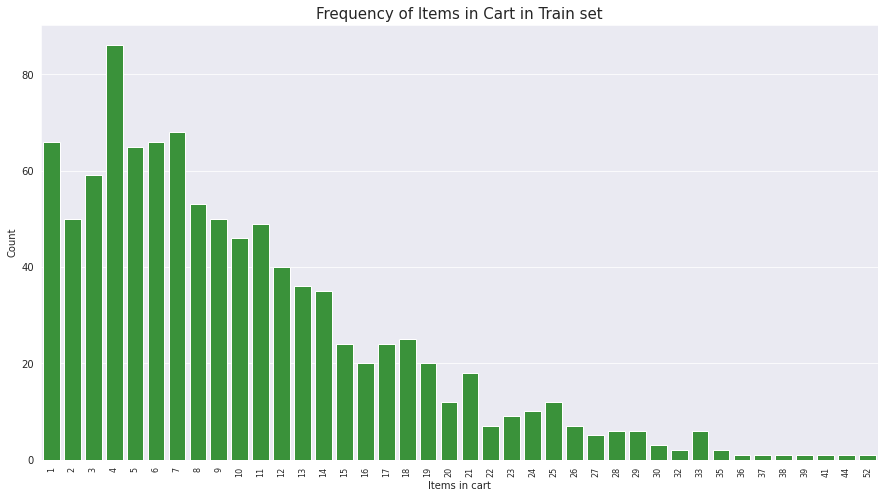

In [49]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(x = add_to_cart_order_train.index, y = add_to_cart_order_train.values, color = color[2])
ax.set_xlabel('Items in cart')
ax.set_ylabel('Count')
ax.xaxis.set_tick_params(rotation=90, labelsize = 8)
ax.set_title('Frequency of Items in Cart in Train set', size = 15)
fig.savefig('./plot/Frequency of Items in Cart in Train set.png')

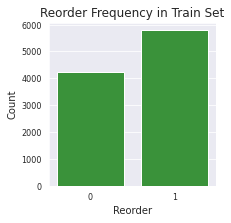

In [50]:
fig, ax = plt.subplots(figsize=(3,3))
ax = sns.barplot(x = order_products_train.reordered.value_counts().index, 
                y = order_products_train.reordered.value_counts().values, color = color[2])
ax.set_xlabel('Reorder', size = 10)
ax.set_ylabel('Count', size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
ax.set_title('Reorder Frequency in Train Set')
fig.savefig('./plot/Reorder Frequency in Train Set')
plt.show()

In [51]:
print('Percentage of reorder in train set:',
      format(order_products_train[order_products_train.reordered == 1].shape[0]*100/order_products_train.shape[0], '.2f'))

Percentage of reorder in train set: 57.81


### products:

This file contains the list of total 49688 products and their aisle as well as department. The number of products in different aisles and different departments are different.

In [52]:
products.head(10)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61.0,19.0
1,2,All-Seasons Salt,104.0,13.0
2,3,Robust Golden Unsweetened Oolong Tea,94.0,7.0
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38.0,1.0
4,5,Green Chile Anytime Sauce,5.0,13.0
5,6,Dry Nose Oil,11.0,11.0
6,7,Pure Coconut Water With Orange,98.0,7.0
7,8,Cut Russet Potatoes Steam N' Mash,116.0,1.0
8,9,Light Strawberry Blueberry Yogurt,120.0,16.0
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115.0,7.0


In [53]:
products.tail()

,product_id,product_name,aisle_id,department_id
9995,9996,Less Sodium Soy Sauce,66.0,6.0
9996,9997,Italian Style Vegetables,116.0,1.0
9997,9998,"""Ice Cream",NaN,NaN
9998,9999,"""Cheese",NaN,NaN
9999,10000,Refresher Strawberry Lemonade,64.0,7.0


In [54]:
len(products.product_name.unique())

9902

In [55]:
len(products.aisle_id.unique())

135

In [56]:
len(products.department_id.unique())

115

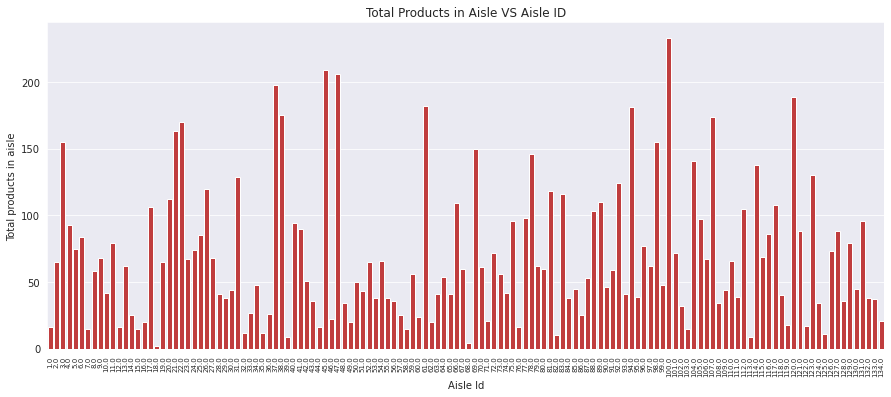

In [57]:
temp_df = products.groupby('aisle_id')['product_id'].count()

fig, ax = plt.subplots(figsize = (15,6))
ax = sns.barplot(x = temp_df.index, y = temp_df.values, color = color[3])
ax.set_xlabel('Aisle Id')
ax.set_ylabel('Total products in aisle')
ax.xaxis.set_tick_params(rotation=90, labelsize = 7)
ax.set_title('Total Products in Aisle VS Aisle ID', size = 12)
fig.savefig('./plot/Total Products in Aisle VS Aisle ID.png')

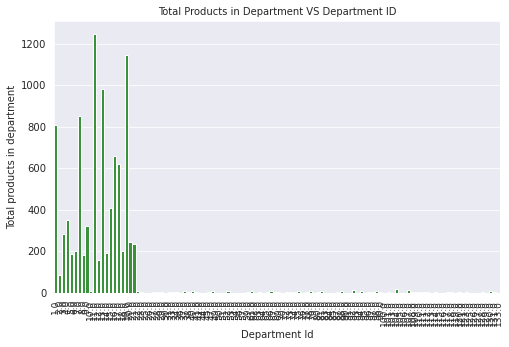

In [58]:
temp_df = products.groupby('department_id')['product_id'].count()

fig, ax = plt.subplots(figsize = (8,5))
ax = sns.barplot(x = temp_df.index, y = temp_df.values, color = color[2])
ax.set_xlabel('Department Id')
ax.set_ylabel('Total products in department')
ax.xaxis.set_tick_params(rotation=90, labelsize = 9)
ax.set_title('Total Products in Department VS Department ID', size = 10)
fig.savefig('./plot/Total Products in Department VS Department ID.png')

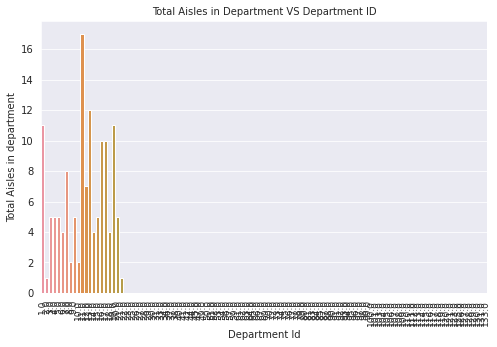

In [59]:
temp_df = products.groupby('department_id')['aisle_id'].nunique()

fig, ax = plt.subplots(figsize = (8,5))
ax = sns.barplot(x = temp_df.index, y = temp_df.values)
ax.set_xlabel('Department Id')
ax.set_ylabel('Total Aisles in department')
ax.xaxis.set_tick_params(rotation=90, labelsize = 9)
ax.set_title('Total Aisles in Department VS Department ID', size = 10)
fig.savefig('./plot/Total Aisles in Department VS Department ID.png')

In [60]:
conn.close()